### The main goal of this notebook is to explore the InSAR4SM `s performance for different spatial resolutions

The performance evaluation is performed for three Sentinel-1 orbits (100, 166, 173) at the ISMN station "FordDryLake" at the spatial resolutions from 50 to 1000 m with a step of 50 meters.

In [1]:
#---------------------Import libraries --------------
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import os
from scipy.stats import pearsonr

#--------------------- INSAR4SM functionalities --------------
from insar4sm.classes import INSAR4SM_stack, SM_point
from insar4sm.gridding import WGS84_to_UTM

Set arguments

In [2]:
ISMN_station = 'FordDryLake'
orbit_time_UTC = '14:00:00'
orbit_num = '173'

combs = [['173','14:00:00'],
         ['100','14:00:00'],
         ['166','02:00:00']]

grid_sizes = np.arange(25, 525, 25)

Function that generates an polygon given center and radius

In [3]:
def create_buffer_poly(ISMN_station_file: str, grid_size: float, save: bool = True ) -> shapely.geometry.polygon.Polygon:

    # convert wgs geometry to projection system

    ISMN_station_loc_wgs84 = gpd.read_file(ISMN_station_file)
    ISMN_station_loc_wgs84.crs = "EPSG:4326"

    lon = ISMN_station_loc_wgs84['geometry'][0].x
    lat = ISMN_station_loc_wgs84['geometry'][0].y
    utm_crs_epsg = WGS84_to_UTM(lon, lat)    

    ISMN_station_loc_UTM = ISMN_station_loc_wgs84.to_crs(epsg=utm_crs_epsg).iloc[0].geometry

    ISMN_station_loc_UTM_buffer = ISMN_station_loc_UTM.buffer(grid_size, cap_style = 1)

    ISMN_station_loc_buffer = gpd.GeoDataFrame(index=[0], crs=utm_crs_epsg, geometry=[ISMN_station_loc_UTM_buffer])

    ISMN_station_loc_buffer = ISMN_station_loc_buffer.to_crs(epsg=4326)

    if save:
        save_dir = os.path.dirname(ISMN_station_file)
        filename = os.path.join(os.path.basename(ISMN_station_file).split('.')[0]+'_'+str(grid_size)+'.geojson')
        ISMN_station_loc_buffer.to_file(os.path.join(save_dir,filename), driver="GeoJSON")  

    return ISMN_station_loc_buffer.geometry



Prepare folder structure

In [4]:
spatial_results = pd.DataFrame(columns=['Orbit_num','orbit_time_UTC','grid_size','rmse', 'r', 'n_DS_pixels'])

for comb in combs:
    orbit_num = comb[0]
    orbit_time_UTC = comb[1]

    for grid_size in grid_sizes:

        ###############################################################################
        # the name of your experiment
        projectname = 'INSAR4SM_ISMN_spatial_{}_sq{}_{}'.format(orbit_num, grid_size, ISMN_station)

        # the directory of the topstack processing
        topstackDir = '/RSL02/SM_NA/Topstack_processing_orbit_{}'.format(orbit_num)

        # the AOI geojson file for your project
        # ensure that AOI is inside your topstack stack
        #AOI = '/RSL02/SM_NA/Plotting/bbox_aoi.geojson'
        AOI = '/RSL02/SM_NA/ISMN/{}/{}_AOI.geojson'.format(ISMN_station,ISMN_station)

        # the meteorological file. You can either provide an ERA5-land file or a csv file with 3 columns (Datetimes, tp__m, skt__K).
        meteo_file = '/RSL02/SM_NA/era5/era5_land_na_orbit_{}.nc'.format(orbit_num)
        # set to True in case you provide an ERA5-Land file
        ERA5_flag = True
        # In case you downloaded surface soil moisture from ERA5-land, set to True for comparison purposes
        ERA5_sm_flag = True

        # the output directory 
        export_dir = '/RSL02/SM_NA/spatial_tests_csv/{}'.format(projectname)

        # soil information datasets (https://soilgrids.org/)
        sand_soilgrids = 87
        clay_soilgrids = 13

        # the insitu measurements in csv format
        ISMN_csv = '/RSL02/SM_NA/ISMN/{}/ismn_station_{}.csv'.format(ISMN_station, ISMN_station)

        # geometrical infromation regarding ISMN station

        ISMN_station_loc = '/RSL02/SM_NA/ISMN/{}/{}_location.geojson'.format(ISMN_station,ISMN_station)

        #IMSN_polygon = gpd.read_file('/RSL02/SM_NA/ISMN/{}/{}_neighborhood.geojson'.format(station_name, station_name))['geometry']

        IMSN_polygon = create_buffer_poly(ISMN_station_loc, grid_size )

        ISMN_point = IMSN_polygon.centroid

        stack = INSAR4SM_stack(topstackDir = topstackDir,
                        projectname = projectname,
                        AOI = AOI,
                        meteo_file = meteo_file,
                        ERA5_flag = ERA5_flag,
                        sand = sand_soilgrids,
                        clay = clay_soilgrids,
                        orbit_time = orbit_time_UTC,
                        export_dir = export_dir)

        stack.prepare_datasets()
        stack.plot()
        stack.get_dry_SARs()
        stack.calc_insar_stack()

        stack.sm_points = ISMN_point
        stack.sm_polygons = IMSN_polygon
        stack.n_sm_points = len(stack.sm_points)

        sm_point_ts = SM_point(stack, sm_ind=0)
        sm_point_ts.get_DS_info(stack)
        sm_point_ts.calc_covar_matrix()
        sm_point_ts.get_DS_geometry(stack)

        sm_point_ts.calc_driest_date()
        #sm_point_ts.driest_date = pd.to_datetime(driest_date)
        sm_point_ts.calc_sm_sorting()

        # in_situ_data = pd.read_csv('/RSL02/SM_NA/comparison_FordDryLake.csv')
        # print(in_situ_data['sm_plot'].loc[sm_point_ts.best_sorting])
        sm_point_ts.calc_sm_coherence()
        sm_point_ts.calc_sm_index()
        sm_point_ts.inversion()

        n_DS_pixels = sm_point_ts.DS_amp_values_amp_ph.shape[1]

        fig, ax = plt.subplots(1,1, figsize=(15, 15))
        img = ax.imshow(sm_point_ts.coh_full_DS[0,:,:])
        y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
        ax.set_yticks(np.arange(len(y_label_list)))
        ax.set_yticklabels(y_label_list)
        fig.colorbar(img)
        plt.title('Driest Date: {}'.format(sm_point_ts.driest_date))
        plt.savefig('{}/Raw_coh_{}_sq{}.png'.format(stack.export_dir, ISMN_station, grid_size), dpi=200)
        plt.close()

        #-- Plotting sm coherence

        fig, ax = plt.subplots(1,1, figsize=(15, 15))
        img = ax.imshow(sm_point_ts.coh_sm[0,:,:])
        y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
        ax.set_yticks(np.arange(len(y_label_list)))
        ax.set_yticklabels(y_label_list)
        fig.colorbar(img)
        plt.savefig('{}/SM_coh_{}_sq{}.png'.format(stack.export_dir, ISMN_station, grid_size), dpi=200)
        plt.close()
            
        #%%###########################################################################
        #-------     Step D: Comparison        -------#
        ##############################################################################

        IMSN_df = pd.read_csv(ISMN_csv)
        IMSN_df.index = pd.to_datetime(IMSN_df['Datetime'])
        IMSN_df = IMSN_df['sm_plot']
        # select only particular hour

        IMSN_df = IMSN_df.at_time(orbit_time_UTC).to_frame()

        #insar4sm_df = pd.DataFrame(np.ones_like(sm_point_ts.best_sorting), columns=['insar4sm'])
        sm_estimations = {'SM0':sm_point_ts.SM0,
                        'SM_index':sm_point_ts.SM_index,
                        'insar4sm':sm_point_ts.sm_inverted
                        }

        insar4sm_df = pd.DataFrame(sm_estimations)
        #insar4sm_df = pd.DataFrame(sm_point_ts.SM_index, columns=['insar4sm'])
        insar4sm_df.index = pd.to_datetime(stack.slc_datetimes)
        insar4sm_df.index = insar4sm_df.index + pd.Timedelta('{} hour'.format(pd.to_datetime(orbit_time_UTC).hour))

        comparison_df = IMSN_df.join(insar4sm_df, how='outer').dropna()
        comparison_df['Datetime'] = comparison_df.index
        comparison_df.to_csv('{}/comparison_{}.csv'.format(stack.export_dir,ISMN_station), index=False)

        predictions = comparison_df['insar4sm'].values
        targets = comparison_df['sm_plot'].values
        n = predictions.shape[0]
        rmse = np.linalg.norm(predictions - targets) / np.sqrt(n)
        r, p_value = pearsonr(predictions, targets)

        comparison_df[['sm_plot', 'SM0', 'SM_index', 'insar4sm']].plot(figsize=(13,13), style='.-')
        plt.title('RMSE: {} m3/m3'.format(round(rmse,2)))

        plt.savefig('{}/SM_estimations_{}_sq{}.png'.format(stack.export_dir, ISMN_station, grid_size), dpi=200)
        plt.savefig('{}/SM_estimations_{}_sq{}.svg'.format(stack.export_dir, ISMN_station, grid_size), format="svg")
        plt.close()
        
        new_row = {'Orbit_num':orbit_num, 'orbit_time_UTC':orbit_time_UTC, 'grid_size':grid_size, 'rmse':rmse, 'r': r, 'n_DS_pixels': n_DS_pixels}
        spatial_results = spatial_results.append(new_row, ignore_index=True)
        print (spatial_results)

spatial_results.to_csv(os.path.join(export_dir,'spatial_results.csv'))

number of SLCs discovered:  23
creating directory: /RSL02/SM_NA/spatial_tests_csv/INSAR4SM_ISMN_spatial_173_sq25_FordDryLake/INSAR4SM_ISMN_spatial_173_sq25_FordDryLake/INSAR4SM_datasets/slcs
write vrt file for each SLC ...
creating stack directory: /RSL02/SM_NA/spatial_tests_csv/INSAR4SM_ISMN_spatial_173_sq25_FordDryLake/INSAR4SM_ISMN_spatial_173_sq25_FordDryLake/INSAR4SM_datasets/coreg_stack
write vrt file for stack directory
creating geometry directory: /RSL02/SM_NA/spatial_tests_csv/INSAR4SM_ISMN_spatial_173_sq25_FordDryLake/INSAR4SM_ISMN_spatial_173_sq25_FordDryLake/INSAR4SM_datasets/geometry
write vrt file for geometry dataset
  Orbit_num orbit_time_UTC grid_size      rmse         r n_DS_pixels
0       173       14:00:00        25  3.564549  0.656957          15
number of SLCs discovered:  23
creating directory: /RSL02/SM_NA/spatial_tests_csv/INSAR4SM_ISMN_spatial_173_sq50_FordDryLake/INSAR4SM_ISMN_spatial_173_sq50_FordDryLake/INSAR4SM_datasets/slcs
write vrt file for each SLC ...

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Style
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

spatial_results = pd.read_csv('/RSL02/SM_NA/spatial_tests_csv/spatial_results.csv')
df = spatial_results.copy()
df.drop(['orbit_time_UTC'], axis=1, inplace = True)
df.grid_size = df.grid_size*2

Plotting RMSE, R and number of pixel for each DS

Text(0.0, 1.0, 'RMSE of INSAR4SM at different spatial resolutions')

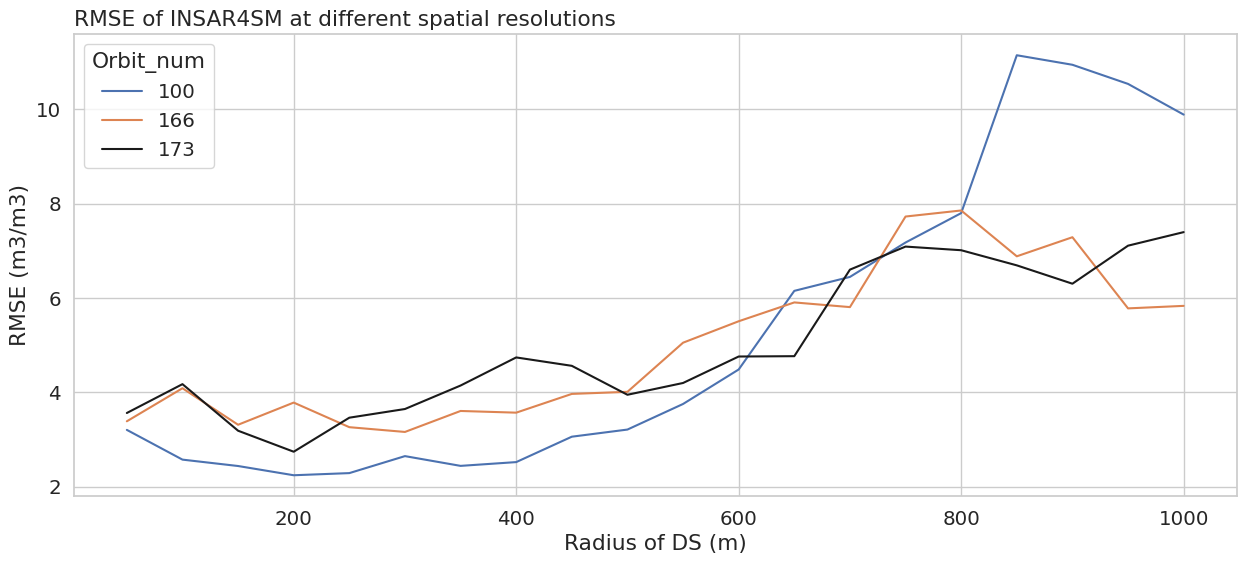

In [77]:
# Plot
fig, ax = plt.subplots(figsize=(15,6))
g1 = sns.lineplot(data=df, x='grid_size', y='rmse', hue="Orbit_num",  palette=["C0", "C1", "k"])
plt.xlabel('Radius of DS (m)')
plt.ylabel('RMSE (m3/m3)')
# Legend
plt.title('RMSE of INSAR4SM at different spatial resolutions', loc='left')

Text(0.0, 1.0, 'R of INSAR4SM at different spatial resolutions')

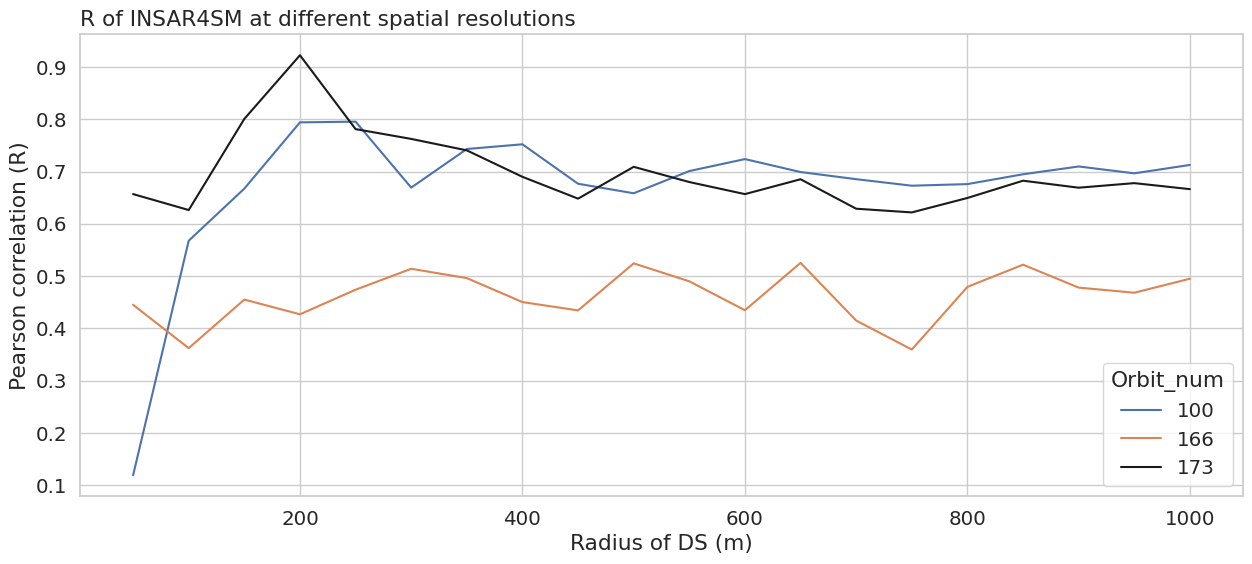

In [78]:
# Plot
fig, ax = plt.subplots(figsize=(15,6))
g1 = sns.lineplot(data=df, x='grid_size', y='r', hue="Orbit_num",  palette=["C0", "C1", "k"])
plt.xlabel('Radius of DS (m)')
plt.ylabel('Pearson correlation (R)')
# Legend
plt.title('R of INSAR4SM at different spatial resolutions', loc='left')

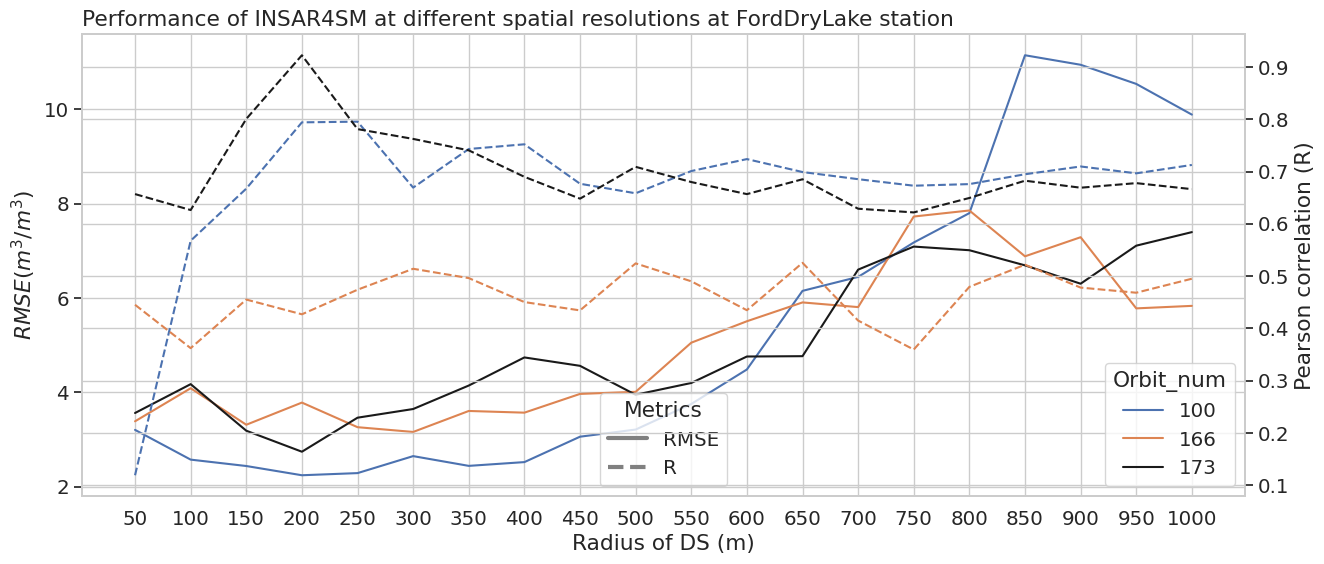

In [80]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot
fig, ax = plt.subplots(figsize=(15,6))
g1 = sns.lineplot(data=df, x='grid_size', y='rmse', hue="Orbit_num",  palette=["C0", "C1", "k"])
plt.xlabel('Radius of DS (m)')
plt.ylabel('$RMSE (m^3/m^3) %$')


line1 = Line2D([0], [0], color='gray', linewidth=3, linestyle='-')
line2 = Line2D([0], [0], color='gray', linewidth=3, linestyle='--')
lines = [line1, line2]
labels = ['RMSE', 'R']
g1.legend(lines, labels, title='Metrics', loc = 'lower center')

#g1.legend(g1.get_legend_handles_labels()[0], [], title='New legend')

ax2 = plt.twinx()
g2 = sns.lineplot(data=df, x='grid_size', y='r', hue="Orbit_num",  palette=["C0", "C1", "k"], linestyle="dashed", ax=ax2)
plt.xlabel('Radius of DS (m)')
plt.ylabel('Pearson correlation (R)')

g2.set(xticks=np.arange(50, 1050, 50))

# Legend
plt.title('Performance of INSAR4SM at different spatial resolutions at FordDryLake station', loc='left')

plt.savefig('/RSL02/SM_NA/spatial_tests_csv/spatial_performance.svg')